In [17]:
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ToTensord,
    LabelFilterd,
    MapLabelValued,
    Invertd,
    EnsureTyped,
    SqueezeDimd,
    Flipd,
    Rotated
)

from monai.networks.nets import UNETR
from monai.data import (
    DataLoader,
    CacheDataset,
)
from monai.inferers import sliding_window_inference
from monailabel.transform.post import BoundingBoxd, Restored

import matplotlib.pyplot as plt

import os
import torch
import numpy as np

In [90]:
img_pth = './radiology/test_data/Patient_01.nii.gz'
lbl_pth = './radiology/test_data/test_labels/Patient_01.nii.gz'
dict = {
    'image': img_pth,
    'label': lbl_pth
}
data = LoadImaged(keys=['image','label'])(dict)
data['image'].shape

(512, 512, 229)

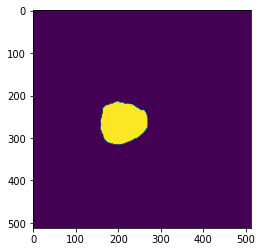

In [92]:
transforms = Compose([
    LoadImaged(keys=['label', 'image']),
    # AddChanneld(keys=['label']),
    # Orientationd(keys=['label'], axcodes="RAS"),
    # SqueezeDimd(keys=['label'],dim=0),
    AddChanneld(keys=['label', 'image']),
    # Orientationd(keys=['label'], axcodes="RPS"),
    # Orientationd(keys=['label'], axcodes="PRI"),
    # Orientationd(keys=['label'], axcodes="RAS"),

    Orientationd(keys=['label', 'image'], axcodes="RPS"),
    SqueezeDimd(keys=['label', 'image'],dim=0),
])
data = transforms(dict)
plt.imshow(data['label'][:, :, 110])

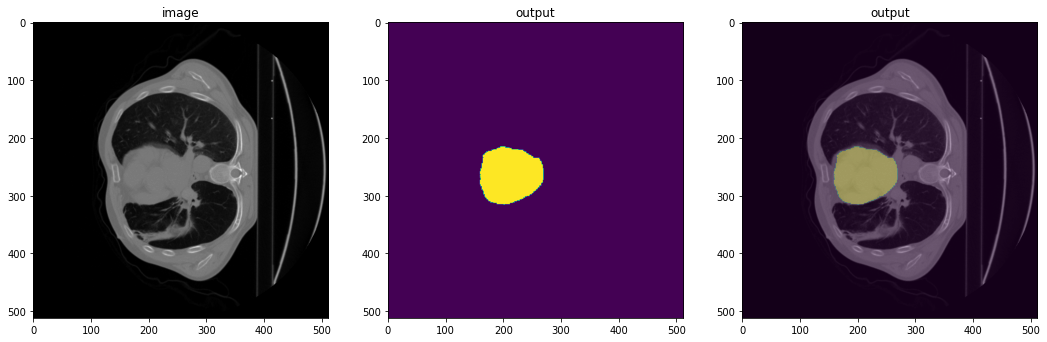

In [93]:
plt.figure("check", (18, 6))
plt.subplot(1, 3, 1)
plt.title(f"image")
plt.imshow(data['image'][:, :, 110], cmap='gray')
plt.subplot(1, 3, 2)
plt.title(f"output")
plt.imshow(data['label'][:, :, 110])
plt.subplot(1, 3, 3)
plt.title(f"output")
plt.imshow(data['image'][:, :, 110], cmap='gray')
plt.imshow(data['label'][:, :, 110],alpha=0.3)
plt.show()

## Infer By DataLoader

In [10]:
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        LabelFilterd(keys=["label"], applied_labels=[2]),
        MapLabelValued(keys=["label"], orig_labels=[0,2], target_labels=[0,1]),
        AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image", "label"]),
    ]
)

In [11]:
def get_dataset_pths(data_dir):
    img_pths = []
    lbl_pths = []
    for patient_dir in sorted(os.listdir(data_dir)):
        img_pths.append(os.path.join(data_dir, patient_dir, f'{patient_dir}.nii.gz'))
        lbl_pths.append(os.path.join(data_dir, patient_dir, f'GT.nii.gz'))
    return img_pths, lbl_pths

In [12]:
root_dir = './'
data_dir = 'D:\\home\\school\\ntut\\dataset\\SegTHOR\\train'

img_pths, lbl_pths = get_dataset_pths(data_dir)
data_dicts = [
    {"image": img_pth, "label": lbl_pth}
    for img_pth, lbl_pth in zip(img_pths, lbl_pths)
]
val_files = data_dicts[:1]

In [13]:
val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=0
)
val_loader = DataLoader(
    val_ds, batch_size=1, shuffle=False, num_workers=0, pin_memory=True
)

Loading dataset: 100%|██████████| 1/1 [00:10<00:00, 10.23s/it]


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=2,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

In [15]:
model_pth = r'D:\home\school\ntut\project\LabelApp\radiology\model\dc_89_best_metric_model.pth'
model.load_state_dict(torch.load(model_pth), strict=False)

_IncompatibleKeys(missing_keys=['vit.patch_embedding.cls_token'], unexpected_keys=[])

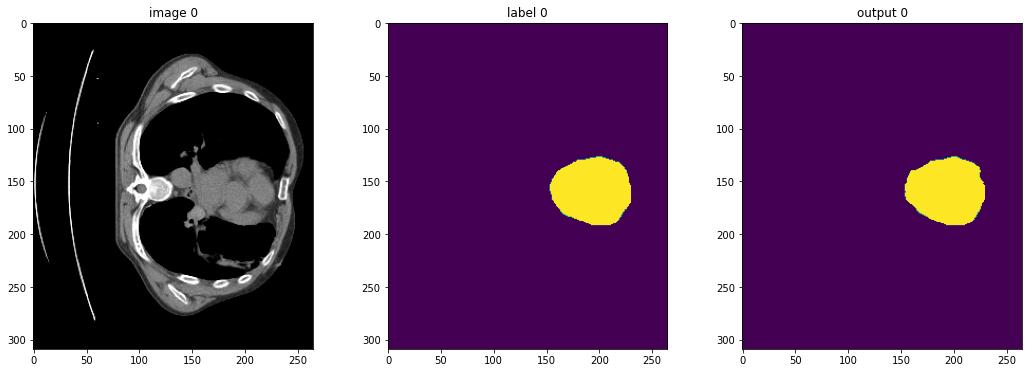

In [17]:
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), (96, 96, 96), 4, model, overlap=0.8
        )
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 110], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 110])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 110])
        plt.show()
        if i == 2:
            break